In [ ]:
import os
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from numba import cuda
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa



# clear GPU memory
cuda.select_device(0)
cuda.close()



In [3]:
# Function to load data from files
def load_data_from_directory(directory):
    texts = []
    labels = []
    for label_dir in ['pos', 'neg']:
        label = 1 if label_dir == 'pos' else 0
        dir_path = os.path.join(directory, label_dir)
        for filename in os.listdir(dir_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(dir_path, filename)
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                    texts.append(content)
                    labels.append(label)
    return texts, labels



In [ ]:
# Load training data
train_directory = 'train/'
train_texts, train_labels = load_data_from_directory(train_directory)

# Load testing data
test_directory = 'test/'
test_texts, test_labels = load_data_from_directory(test_directory)

# Split training data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

# Initialize the tokenizer from DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')



In [5]:


# Tokenize the texts
tokenized_train_reviews = tokenizer(train_texts, padding=True, truncation=True, max_length=250, return_tensors='tf')
tokenized_val_reviews = tokenizer(val_texts, padding=True, truncation=True, max_length=250, return_tensors='tf')
tokenized_test_reviews = tokenizer(test_texts, padding=True, truncation=True, max_length=250, return_tensors='tf')



In [ ]:
# Load DistilBERT model with classification head
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2, dropout=0.3)

In [14]:


# Compile the model with an appropriate optimizer, loss function, and metric
model.compile(optimizer = tfa.optimizers.AdamW(learning_rate=2e-5, weight_decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping_lose = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
early_stopping_accuracy = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)


In [15]:
# Train the model
history = model.fit(tokenized_train_reviews['input_ids'], 
                    tf.convert_to_tensor(train_labels), 
                    validation_data=(tokenized_val_reviews['input_ids'], tf.convert_to_tensor(val_labels)),
                    epochs=10, 
                    batch_size=16,
                    callbacks=[early_stopping_lose, early_stopping_accuracy])

Epoch 1/10
1250/1250 [==============================] - 310s 246ms/step - loss: 0.3296 - accuracy: 0.8538 - val_loss: 0.2504 - val_accuracy: 0.8982
Epoch 2/10
1250/1250 [==============================] - 291s 233ms/step - loss: 0.2250 - accuracy: 0.9096 - val_loss: 0.2251 - val_accuracy: 0.9126
Epoch 3/10
1250/1250 [==============================] - 278s 223ms/step - loss: 0.1669 - accuracy: 0.9371 - val_loss: 0.2638 - val_accuracy: 0.9060
Epoch 4/10
1250/1250 [==============================] - 279s 223ms/step - loss: 0.1233 - accuracy: 0.9538 - val_loss: 0.3100 - val_accuracy: 0.9078


In [16]:
# Evaluate the model on the test set
score = model.evaluate(tokenized_test_reviews['input_ids'], tf.convert_to_tensor(test_labels))

782/782 [==============================] - 90s 115ms/step - loss: 0.2303 - accuracy: 0.9102


In [17]:

# Generate predictions
predictions = model.predict(tokenized_test_reviews['input_ids'])
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)


# Print the calculated metrics
print(f'Test score or loss: {score[0]:.4f}')   # Loss
print(f'Test accuracy: {score[1]:.4f}')         # Accuracy
print(f'Test Precision: {precision:.4f}')  # Precision
print(f'Test Recall: {recall:.4f}')        # Recall
print(f'Test F1 Score: {f1:.4f}')          # F1 Score





782/782 [==============================] - 89s 113ms/step
Test score or loss: 0.2303
Test accuracy: 0.9102
Test Precision: 0.9109
Test Recall: 0.9094
Test F1 Score: 0.9101


In [18]:
# Generate predictions
predictions = model.predict(tokenized_test_reviews['input_ids'])
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

# Print first 10 predictions and true labels (modify as necessary)
for i in range(10):
    print(f"Review {i+1}: Predicted label: {predicted_labels[i]}, True label: {test_labels[i]}")

for j in range(20000, 20010):
    print(f"Review {j}: Predicted label: {predicted_labels[j]}, True label: {test_labels[j]}")

# Generate classification report
print(classification_report(test_labels, predicted_labels, target_names=['Negative', 'Positive']))

782/782 [==============================] - 90s 115ms/step
Review 1: Predicted label: 1, True label: 1
Review 2: Predicted label: 1, True label: 1
Review 3: Predicted label: 1, True label: 1
Review 4: Predicted label: 1, True label: 1
Review 5: Predicted label: 1, True label: 1
Review 6: Predicted label: 1, True label: 1
Review 7: Predicted label: 1, True label: 1
Review 8: Predicted label: 1, True label: 1
Review 9: Predicted label: 1, True label: 1
Review 10: Predicted label: 1, True label: 1
Review 20000: Predicted label: 0, True label: 0
Review 20001: Predicted label: 0, True label: 0
Review 20002: Predicted label: 0, True label: 0
Review 20003: Predicted label: 0, True label: 0
Review 20004: Predicted label: 0, True label: 0
Review 20005: Predicted label: 0, True label: 0
Review 20006: Predicted label: 0, True label: 0
Review 20007: Predicted label: 0, True label: 0
Review 20008: Predicted label: 0, True label: 0
Review 20009: Predicted label: 0, True label: 0
              precisi

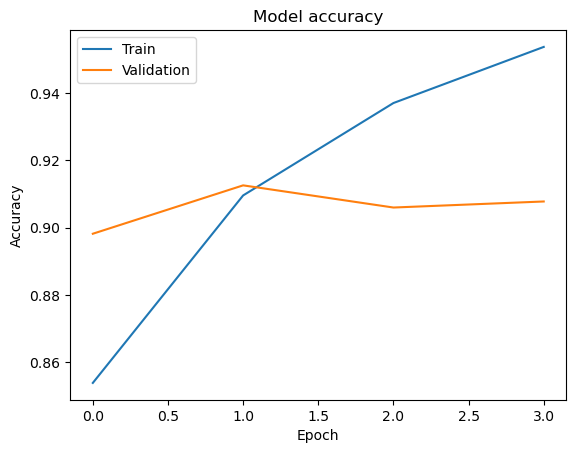

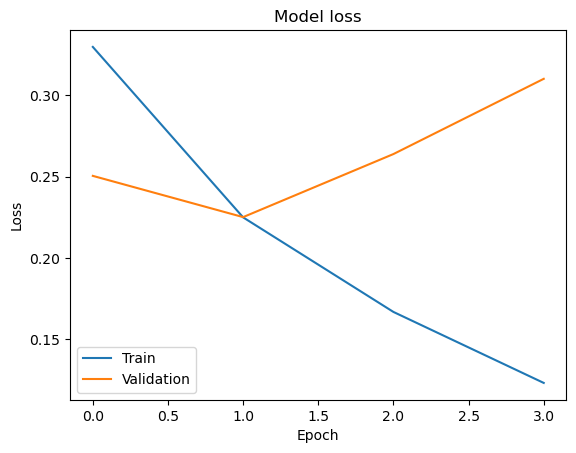

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()